In [1]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim

from simple_custom_taxi_env import SimpleTaxiEnv
from utils import select_action, get_state_tensor
from TaxiMemory import TaxiMemory
from dqn_net import DQN


# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Classes

In [2]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Initialize

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.3
TAU = 0.005
LR = 1e-4
MAX_FUEL = 50
num_episodes = 1000
log_steps = 100
partial_prob = 1

In [ ]:
# env = SimpleTaxiEnv(fuel_limit=MAX_FUEL)
# state, info = env.reset()
n_observations = 23
n_actions = 6

policy_net = DQN(n_observations, n_actions).to(device)
# policy_net.load_state_dict(torch.load("DQN.pt"))
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
taxi_memory = TaxiMemory()


def get_epsilon(epsilon_start, epsilon_end, total, current):
    adjust_term = -epsilon_end * current / total
    k = math.log(epsilon_start / epsilon_end) / total
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * (
        math.exp(-k * current) + adjust_term
    )
    return epsilon


episode_durations = []
episodic_rewards = []


def plot_durations_and_rewards(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    rewards_t = torch.tensor(episodic_rewards, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    plt.xlabel("Episode")
    # plt.ylabel('Duration')
    plt.plot(durations_t.numpy(), label="duration")
    plt.plot(rewards_t.numpy(), label="rewards")
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), label="smooth duration")
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), label="smooth rewards")

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [5]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = (
            target_net(non_final_next_states).max(1).values
        )
    td_target = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, td_target.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [6]:
def env_jump_before_pick(env, taxi_memory, k=1):
    '''
    k=0-3
    '''
    if k == 0:
        return env.get_state()
    dest_idx = env.stations.index(env.destination)
    locations_idx = list(range(4)) # all
    locations_idx.remove(env.stations.index(env.passenger_loc)) # remove goal
    locations_idx = random.sample(locations_idx, k) # shrink to k

    env.taxi_pos = env.stations[random.choice(locations_idx)]

    for idx in locations_idx:
        taxi_memory.visit_mask[idx] = 0
    if dest_idx in locations_idx:
        taxi_memory.destination_mask[dest_idx] = 1
    return env.get_state()

def env_jump_after_pick(env, taxi_memory, k=1):
    '''
    k=0-3
    '''
    if k == 0:
        env.get_state()
    dest_idx = env.stations.index(env.destination)
    passenger_idx = env.stations.index(env.passenger_loc)
    locations_idx = list(range(4)) # all
    locations_idx.remove(passenger_idx) # remove passenger and add it back later
    locations_idx = random.sample(locations_idx, k-1) # shrink to k-1
    locations_idx.append(passenger_idx)

    env.taxi_pos = env.passenger_loc
    env.step(4)

    taxi_memory.passenger_picked_up = True
    for idx in locations_idx:
        taxi_memory.visit_mask[idx] = 0
    if dest_idx in locations_idx:
        taxi_memory.destination_mask[dest_idx] = 1
    return env.get_state()


In [7]:
env = SimpleTaxiEnv(fuel_limit=MAX_FUEL, partial=True)
state, info = env.reset()
taxi_memory.reset(state)
twist_level = np.random.randint(0, 4)
print(twist_level)
state = env_jump_before_pick(env, taxi_memory, twist_level) # spectial setting
get_state_tensor(state, taxi_memory, device)

2


tensor([[-2.,  1., -2., -2.,  2., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
          0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]], device='cuda:2')

In [8]:
env = SimpleTaxiEnv(fuel_limit=MAX_FUEL, partial=False)
state, info = env.reset()
print(env.passenger_loc)
taxi_memory.reset(state)
twist_level = np.random.randint(1, 4)
print(twist_level)
state = env_jump_after_pick(env, taxi_memory, twist_level)
get_state_tensor(state, taxi_memory, device)

(1, 1)
2


tensor([[2., 0., 0., 0., 3., 2., 0., 2., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
         1., 0., 0., 0., 0.]], device='cuda:2')

# Train

In [16]:
import time

[99] Avg reward=-167.5449999999999, Avg duration=46.95
[199] Avg reward=-146.74099999999987, Avg duration=45.41
[299] Avg reward=-121.14399999999989, Avg duration=43.44
[399] Avg reward=-97.78799999999993, Avg duration=41.88
[499] Avg reward=-78.66999999999996, Avg duration=41.2
[599] Avg reward=-63.25699999999997, Avg duration=40.57
[699] Avg reward=-58.76899999999997, Avg duration=41.19
[799] Avg reward=-37.067, Avg duration=37.17
[899] Avg reward=-32.702000000000005, Avg duration=37.52
[999] Avg reward=-32.447000000000024, Avg duration=40.47
Complete


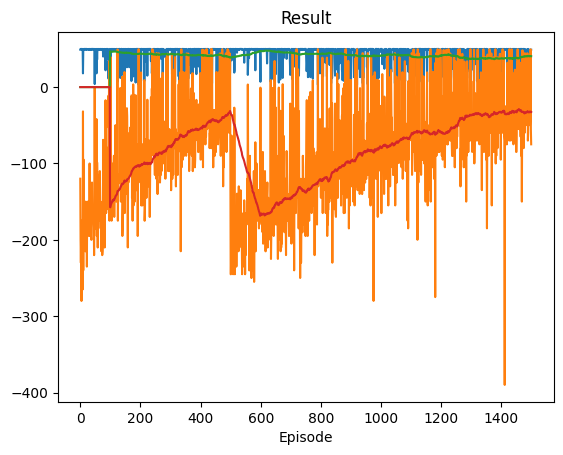

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    # print("RESET-------------")
    epsilon = get_epsilon(EPS_START, EPS_END, num_episodes, i_episode)
    total_reward = 0
    use_partial = random.random() < partial_prob
    if use_partial:
        env = SimpleTaxiEnv(fuel_limit=MAX_FUEL, partial=True)
    else:
        env = SimpleTaxiEnv(fuel_limit=MAX_FUEL, partial=False)
    state, info = env.reset()
    taxi_memory.reset(state)
    if use_partial:
        twist_level = np.random.randint(0, 4)
        state = env_jump_before_pick(env, taxi_memory, twist_level) # spectial setting
    else:
        twist_level = np.random.randint(1, 4)
        state = env_jump_after_pick(env, taxi_memory, twist_level) # spectial setting
    state = get_state_tensor(state, taxi_memory, device)

    for t in count():
        action = select_action(policy_net, state, device, epsilon)
        next_state, reward, done, _ = env.step(action.item())

        old_visited = taxi_memory.visit_mask
        if not done or done and (t == MAX_FUEL - 1):  # trucated
            next_state = get_state_tensor(next_state, taxi_memory, device, action.item())
        else:  # terminated
            next_state = None
        new_visited = taxi_memory.visit_mask
        
        augmented_reward = sum(old_visited) - sum(new_visited)
        reward += augmented_reward * 2
        total_reward += reward
        reward = torch.tensor([reward], device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[
                key
            ] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            episodic_rewards.append(total_reward)
            # plot_durations_and_rewards()
            if (i_episode + 1) % log_steps == 0:
                print(f"[{i_episode}] Avg reward={np.average(episodic_rewards[-100:])}, Avg duration={np.average(episode_durations[-100:])}")
            break

print("Complete")
plot_durations_and_rewards(show_result=True)
plt.ioff()
plt.show()

In [15]:
torch.save(policy_net.state_dict(), "DQN.pt")